<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/ML-Manuel/RF%26LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

In [60]:
!git clone -b ML-Manuel https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

fatal: destination path 'DATCapstone' already exists and is not an empty directory.
/content/DATCapstone/data/DATCapstone/data


In [61]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [62]:


df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
149,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,NaN,NaN,NaN,NaN,NaN,1.128571,1.756653,10.863785,9.008606,AAPL
152,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,-3.444626,0.245331,7.016815,0.616699,AAPL
155,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.933334,3.601639,9.637100,-0.162491,AAPL
158,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,0.873398,0.392532,8.744034,2.098389,AAPL
161,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.265976,-1.069687,9.313263,4.827057,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,2025-01-27,394.799988,406.690002,389.000000,397.149994,58125500,0.0,0.0,29723.864,4.0,...,1.174326,-0.262426,0.298183,0.182200,0.388200,0.940002,NaN,NaN,NaN,TSLA
8072,2025-01-28,396.910004,400.589996,386.500000,398.089996,48910700,0.0,0.0,29723.864,4.0,...,0.084330,-0.354550,-0.611864,-0.449780,0.584349,-8.989990,NaN,NaN,NaN,TSLA
8082,2025-01-29,395.209991,398.589996,384.480011,389.100006,68033600,0.0,0.0,29723.864,4.0,...,0.827862,-0.620100,-0.024186,-0.439615,0.781107,11.179993,NaN,NaN,NaN,TSLA
8092,2025-01-30,410.779999,412.500000,384.410004,400.279999,98092900,0.0,0.0,29723.864,4.0,...,1.383147,-0.616897,-0.145329,-0.418483,0.636253,4.320007,NaN,NaN,NaN,TSLA


In [63]:
#Read Data
# df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
# Correct path for ZIP file
zip_path = '/content/DATCapstone/data/_data.csv.zip'

# Extract specific file from ZIP
with ZipFile(zip_path, 'r') as z:
    with z.open('data.csv') as f:  # Explicitly specify the file to extract
        df = pd.read_csv(f, index_col=0)


df['Date'] = pd.to_datetime(df['Date'])

#Forward fill -> micro, macro, stock / fill na -> sentiment
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])

# Sorting
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# Lag feature (Exclude embedding columns)
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7, 14, 30]
lag_features = []

for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

lag_df = pd.concat(lag_features, axis=1)

df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

In [64]:
import glob
import pandas as pd

# Correct path for article CSVs in Google Colab
csv_files = glob.glob('/content/DATCapstone/data/*articles*.csv')
print("Found files:", csv_files)  # Debugging


Found files: ['/content/DATCapstone/data/MSFT_articles..csv', '/content/DATCapstone/data/AAPL_articles.csv', '/content/DATCapstone/data/ADBE_articles.csv', '/content/DATCapstone/data/AVGO_articles..csv', '/content/DATCapstone/data/AMZN_articles..csv', '/content/DATCapstone/data/META_articles..csv', '/content/DATCapstone/data/NFLX_articles..csv', '/content/DATCapstone/data/TSLA_articles..csv', '/content/DATCapstone/data/GOOGL_articles..csv', '/content/DATCapstone/data/NVDA_articles..csv']


In [65]:
!ls /content/DATCapstone/data/*articles*.csv


/content/DATCapstone/data/AAPL_articles.csv
/content/DATCapstone/data/ADBE_articles.csv
/content/DATCapstone/data/AMZN_articles..csv
/content/DATCapstone/data/AVGO_articles..csv
/content/DATCapstone/data/GOOGL_articles..csv
/content/DATCapstone/data/META_articles..csv
/content/DATCapstone/data/MSFT_articles..csv
/content/DATCapstone/data/NFLX_articles..csv
/content/DATCapstone/data/NVDA_articles..csv
/content/DATCapstone/data/TSLA_articles..csv


In [66]:
if not csv_files:
    print("No article files found. Initializing empty columns.")
    df_articles = pd.DataFrame(columns=['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive'])
else:
    # Your existing processing code
    df_articles_list = []
    for file in csv_files:
        ticker = os.path.basename(file).split('_')[0]
        df_articles = pd.read_csv(file)
        df_articles['Ticker'] = ticker
        df_articles_list.append(df_articles)

    df_articles = pd.concat(df_articles_list, ignore_index=True)

    # Preprocessing steps...
# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

In [67]:
import glob

# Read articles df
csv_files = glob.glob(os.path.join("*_articles*.csv")) # Updated to reflect file naming pattern

df_articles_list = []

for file in csv_files:
    # get ticker from filename
    ticker = os.path.basename(file).split('_')[0]
    df_articles = pd.read_csv(file)
    df_articles['Ticker'] = ticker
    df_articles_list.append(df_articles)

# concat articles dataframe
df_articles = pd.concat(df_articles_list, ignore_index=True)

# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

In [68]:
print(df_articles.columns)

Index(['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral',
       'Articles_positive', 'Articles_avg_sentiment'],
      dtype='object')


# ML Linear


In [70]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# PCA columns
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)
df_non_pca = df.drop(columns=emb_cols)

df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_74,emb_pca_75,emb_pca_76,emb_pca_77,emb_pca_78,emb_pca_79,emb_pca_80,emb_pca_81,emb_pca_82,emb_pca_83
0,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
1,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
2,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 20, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 20.3420
Mean Absolute Error (MAE): 2.9514
R² Score: -0.5414


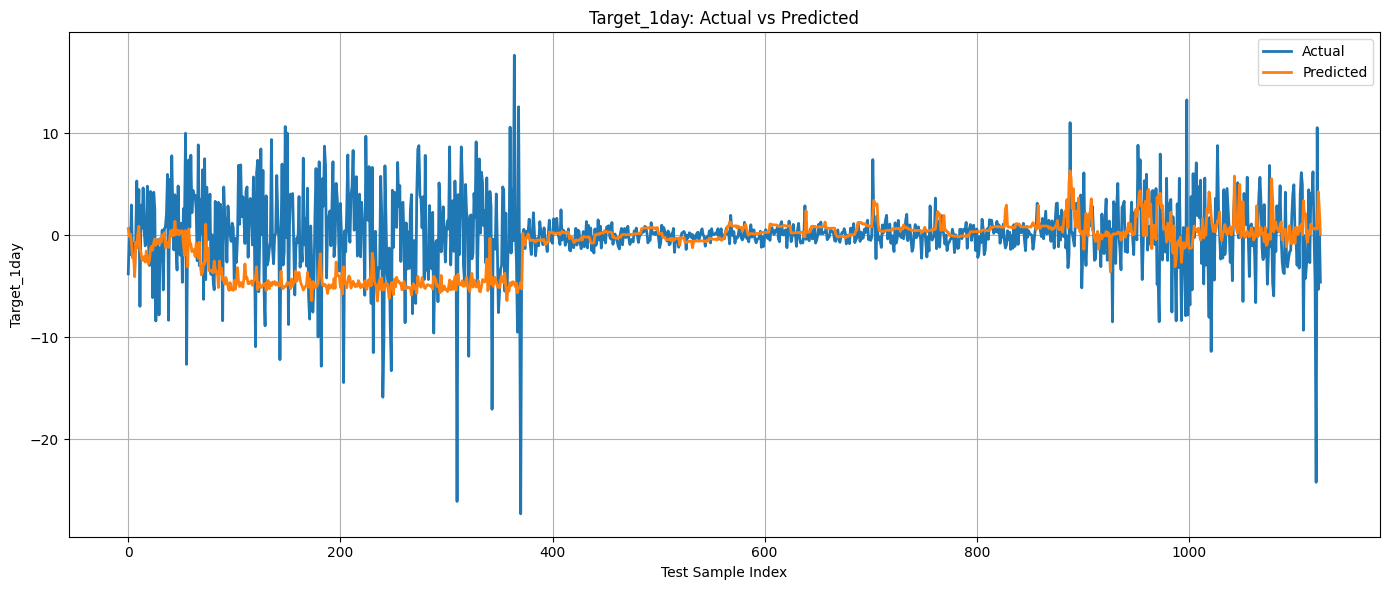

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 50.5446
Mean Absolute Error (MAE): 4.9216
R² Score: 0.1119


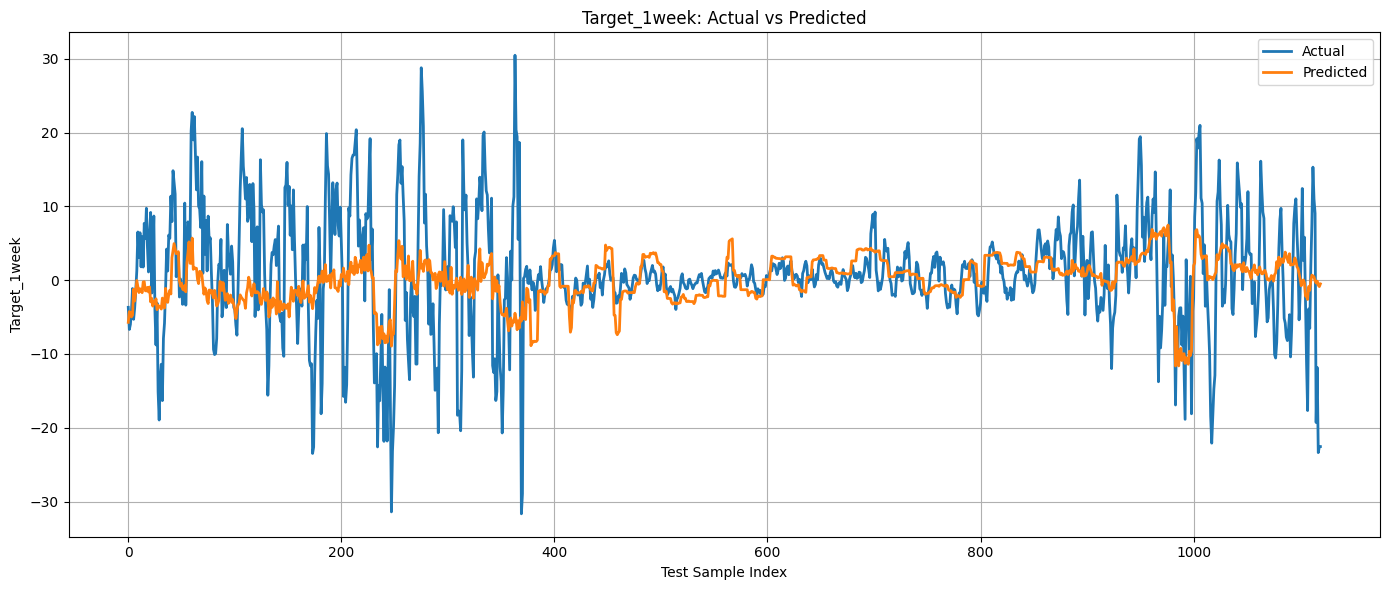

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': None, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 179.8273
Mean Absolute Error (MAE): 9.6425
R² Score: 0.0685


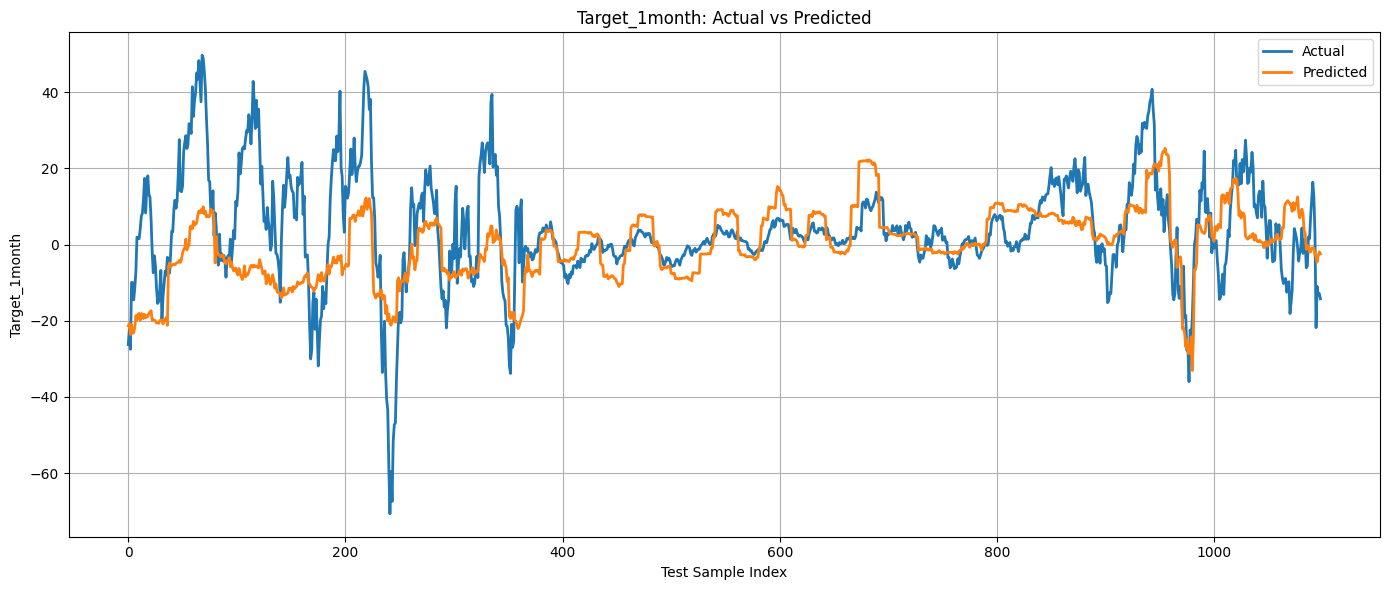

Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

In [ ]:
random_forest(df, 'Target_1day')
random_forest(df, 'Target_1week')
random_forest(df, 'Target_1month')
random_forest(df, 'Target_1year')

In [ ]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()

    # Target setting
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    df['Date'] = pd.to_datetime(df['Date'])

    # Ticker encoding
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
lightgbm_model(df, 'Target_1day')
lightgbm_model(df, 'Target_1week')
lightgbm_model(df, 'Target_1month')
lightgbm_model(df, 'Target_1year')

In [ ]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')

# TFT

## Functional, needs improvement

In [ ]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'GDP (Billions USD)', 'Unemployment Rate (%)',
       ...
       'positive_lag14', 'positive_lag30', 'Articles_Negative_x',
       'Articles_Neutral_x', 'Articles_positive_x', 'Articles_avg_sentiment_x',
       'Articles_Negative_y', 'Articles_Neutral_y', 'Articles_positive_y',
       'Articles_avg_sentiment_y'],
      dtype='object', length=1083)


In [ ]:
#!pip install pytorch_forecasting
#!pip install lightning

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from sklearn.decomposition import PCA

In [ ]:
# Data Prep
required_columns = ['Date', 'Ticker', 'Target_1day', 'Open', 'High', 'Low', 'Close',
                   'Volume', 'GDP (Billions USD)', 'Unemployment Rate (%)',
                   'positive', 'neutral', 'negative'] + [f"emb_{i}" for i in range(768)]

df = df[required_columns].sort_values(by=['Ticker', 'Date'])

# Create time index
df["time_idx"] = df.groupby("Ticker").cumcount()


In [ ]:
# Define TimeSeriesDataSet ⚙️
max_encoder_length = 30  # 30-day lookback window
max_prediction_length = 1  # 1-day prediction

training_cutoff = int(df["time_idx"].max() * 0.8)  # 80-20 time-based split

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Target_1day",
    group_ids=["Ticker"],
    static_categoricals=["Ticker"],
    time_varying_known_reals=[
        'Open', 'High', 'Low', 'Volume',
        'GDP (Billions USD)', 'Unemployment Rate (%)'
    ],
    time_varying_unknown_reals=[
        'Close', 'positive', 'negative', 'neutral'
    ] + [f"emb_{i}" for i in range(768)],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    target_normalizer=GroupNormalizer(groups=["Ticker"], transformation="softplus"),
)

In [ ]:
# Dataloaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

In [ ]:
# Configure TFT Model
tft = TemporalFusionTransformer.from_dataset(
    training,
    hidden_size=32,
    lstm_layers=2,
    dropout=0.1,
    output_size=7,  # Changed to 7 to match the desired number of quantiles
    loss=QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), # Explicitly set quantiles
    learning_rate=0.03,
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
# Train Model
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-tft-{epoch}-{val_loss:.2f}",
    save_top_k=1,
    monitor="val_loss"
)

# Create ModelCheckpoint instance
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",  # Automatically detects GPU/TPU
    devices="auto",      # Uses all available devices
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10),
        LearningRateMonitor(),
        checkpoint_callback
    ],
    enable_progress_bar=True,
    enable_model_summary=True
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Running will take a while

In [ ]:
# Evaluate Model
predictions = tft.predict(val_dataloader, mode="prediction", return_x=False) # Added parameters

# Updated line to move predictions to the CPU if needed
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).cpu() #.cpu() to ensure tensors are on the same device

# Check MAE
mae = (actuals - predictions.cpu()).abs().mean() # predictions.cpu() moves tensors to cpu
print(f"MAE: {mae:.2f}")

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE: 4.32


### Visuals of Model Performance

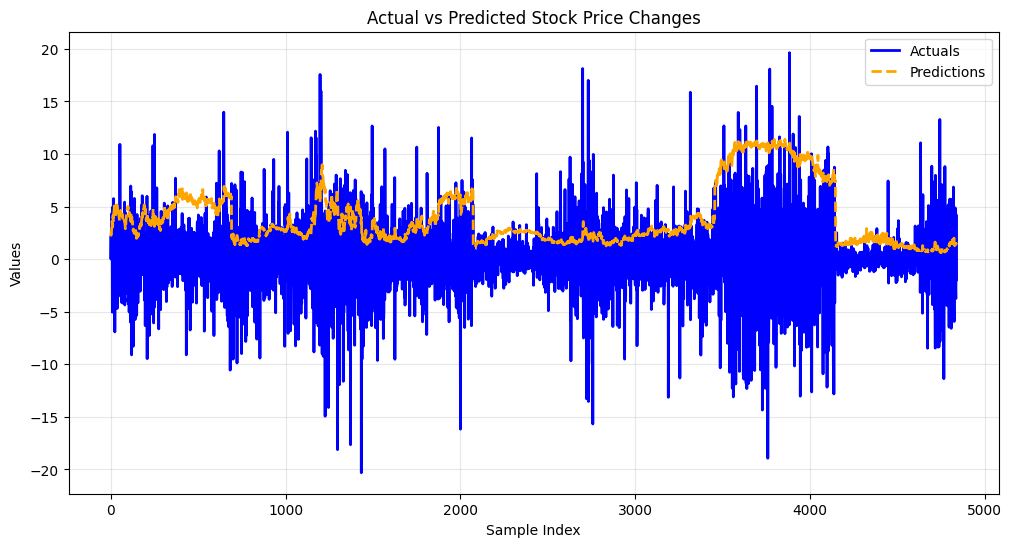

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals.numpy(), label="Actuals", color="blue", linewidth=2)
plt.plot(predictions.cpu().numpy(), label="Predictions", color="orange", linestyle="--", linewidth=2) # Move predictions to CPU before converting to NumPy
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Actual vs Predicted Stock Price Changes")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

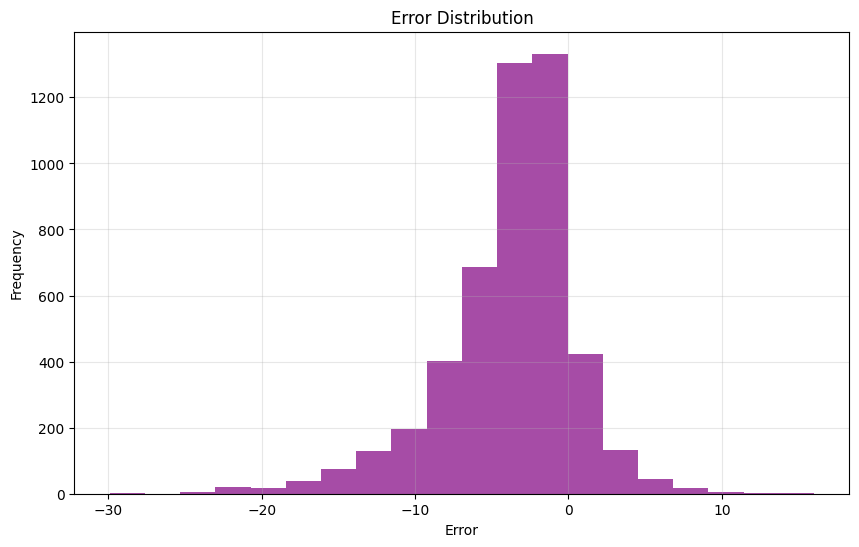

In [ ]:
# Calculate errors
errors = actuals.cpu().numpy() - predictions.cpu().numpy()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color="purple", alpha=0.7)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.grid(alpha=0.3)
plt.show()

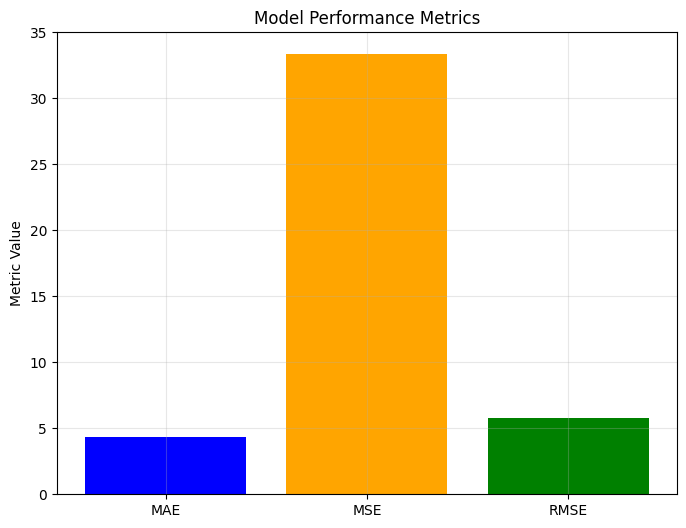

In [ ]:
# Example metrics
metrics = {"MAE": mae.item(), "MSE": (errors**2).mean(), "RMSE": (errors**2).mean()**0.5}

# Plot metrics summary
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=["blue", "orange", "green"])
plt.ylabel("Metric Value")
plt.title("Model Performance Metrics")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
#Save Model 💾
torch.save(tft.state_dict(), "tft_model.pth")

## New TFT

### Installs

In [ ]:
# %%capture
!pip install pytorch_lightning==2.2.0 pytorch_forecasting==1.3.0
!pip install torch==2.3.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting

In [184]:
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet, GroupNormalizer, QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Create directory for checkpoints
os.makedirs("tft_checkpoints", exist_ok=True)

### Setup

In [185]:
def prepare_tft_dataset(df, target_column='Target_1day', max_encoder_length=30, max_prediction_length=1):
    """
    Prepare stock data for Temporal Fusion Transformer with enhanced data cleaning
    and proper temporal grouping.
    """
    # Create working copy of dataframe
    df_tft = df.copy()

    # 1. Sort data chronologically within ticker groups
    df_tft = df_tft.sort_values(by=['Ticker', 'Date'])

    # 2. Calculate targets PROPERLY with group-aware shifting
    # ------------------------------------------------------
    df_tft[target_column] = df_tft.groupby('Ticker')['Close'].transform(
        lambda x: x.shift(-1) - x  # Calculate next-day price change
    )

    # 3. Handle infinite values and missing data
    # ------------------------------------------
    df_tft.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 4. Create initial time index BEFORE filtering
    # ---------------------------------------------
    df_tft['time_idx'] = df_tft.groupby('Ticker').cumcount()

    # 5. Filter rows with valid target values and essential features
    # --------------------------------------------------------------
    required_columns = [
        'Date', 'Ticker', target_column,
        'Open', 'High', 'Low', 'Close', 'Volume',
        'Dividends', 'Stock Splits', 'time_idx'
    ] + [f'emb_{i}' for i in range(768) if f'emb_{i}' in df_tft.columns]

    df_tft = df_tft.dropna(subset=required_columns)

    # 6. Rebuild time index AFTER filtering to ensure continuity
    # ----------------------------------------------------------
    df_tft['time_idx'] = df_tft.groupby('Ticker').cumcount()

    # 7. Add temporal features
    # ------------------------
    df_tft['day_of_week'] = pd.to_datetime(df_tft['Date']).dt.dayofweek
    df_tft['month'] = pd.to_datetime(df_tft['Date']).dt.month
    df_tft['year'] = pd.to_datetime(df_tft['Date']).dt.year

    # 8. Define dataset parameters
    # ----------------------------
    known_reals = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'Dividends', 'Stock Splits', 'day_of_week',
        'month', 'year'
    ]
    known_reals = [col for col in known_reals if col in df_tft.columns]

    unknown_reals = [
        'negative', 'neutral', 'positive'
    ] + [f'emb_{i}' for i in range(50) if f'emb_{i}' in df_tft.columns]

     # 9. Create training/validation split with proper index handling
    # -------------------------------------------------------------
    # Calculate max time index per ticker
    max_time = df_tft.groupby('Ticker')['time_idx'].max().reset_index(name='max_time')

    # Merge max_time back to original dataframe with index reset
    df_tft = df_tft.merge(max_time, on='Ticker', how='left').reset_index(drop=True)

    # Calculate cutoff as 80% of max_time
    df_tft['train_cutoff'] = (df_tft['max_time'] * 0.8).astype(int)

    # 10. Create aligned training mask
    training_mask = (df_tft['time_idx'] <= df_tft['train_cutoff']).values  # Convert to numpy array

    # 11. Build TimeSeriesDataSet with aligned indexes
    training = TimeSeriesDataSet(
        df_tft.iloc[training_mask],  # Use index-based selection
        time_idx="time_idx",
        target=target_column,
        group_ids=["Ticker"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=["Ticker"],
        time_varying_known_reals=known_reals,
        time_varying_unknown_reals=unknown_reals,
        target_normalizer=GroupNormalizer(
            groups=["Ticker"],
            transformation="softplus"
        ),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # Create validation set with index alignment
    validation = TimeSeriesDataSet.from_dataset(
        training,
        df_tft,
        min_prediction_idx=df_tft['train_cutoff'].iloc[0] + 1  # Use scalar value
    )

    return training, validation


In [186]:
def train_tft_model(training, validation, batch_size=64, max_epochs=30):
    """
    Create and train a Temporal Fusion Transformer model
    """
    # Create dataloaders
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

    # Define TFT model
    tft = TemporalFusionTransformer.from_dataset(
        training,
        hidden_size=64,              # Size of hidden layers
        attention_head_size=4,       # Number of attention heads
        dropout=0.1,                 # Dropout rate
        hidden_continuous_size=32,   # Hidden size for processing continuous variables
        lstm_layers=2,               # Number of LSTM layers
        output_size=7,               # Number of quantiles to predict
        loss=QuantileLoss(           # Quantile loss for probabilistic forecasting
            quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
        ),
        learning_rate=0.01,          # Learning rate
        log_interval=10,             # Log every 10 batches
        reduce_on_plateau_patience=4,# Reduce LR after 4 epochs without improvement
    )

    # Define callbacks
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=False,
        mode="min"
    )

    lr_logger = LearningRateMonitor()

    checkpoint_callback = ModelCheckpoint(
        dirpath="./tft_checkpoints/",
        filename="{epoch}-{val_loss:.2f}",
        save_top_k=1,
        verbose=True,
        monitor="val_loss",
        mode="min"
    )

    # Configure trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",          # Will use T4 GPU automatically
        devices="auto",              # Use available devices
        gradient_clip_val=0.1,       # Clip gradients to avoid exploding gradients
        callbacks=[
            early_stop_callback,
            lr_logger,
            checkpoint_callback
        ],
        logger=True,
        log_every_n_steps=10,
    )

    # Fit the model
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    return tft, trainer, checkpoint_callback


In [187]:
def evaluate_tft_model(tft, validation, batch_size=64):
    """
    Evaluate the TFT model performance
    """
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

    # Make predictions
    predictions = tft.predict(val_dataloader)

    # Get actual values
    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

    # Calculate metrics using the median prediction (quantile 0.5)
    median_idx = 3  # Index of the 0.5 quantile
    point_predictions = predictions[:, median_idx]

    # Calculate Mean Absolute Error
    mae = (actuals - point_predictions).abs().mean()

    # Calculate Mean Squared Error
    mse = ((actuals - point_predictions) ** 2).mean()

    # Calculate Root Mean Squared Error
    rmse = torch.sqrt(mse)

    # Calculate R² score
    y_mean = actuals.mean()
    ss_tot = ((actuals - y_mean) ** 2).sum()
    ss_res = ((actuals - point_predictions) ** 2).sum()
    r2 = 1 - (ss_res / ss_tot)

    metrics = {
        "MAE": mae.item(),
        "MSE": mse.item(),
        "RMSE": rmse.item(),
        "R2": r2.item()
    }

    return metrics, actuals, predictions


In [188]:
def visualize_results(actuals, predictions, target_name):
    """
    Visualize model predictions
    """
    # Convert tensors to numpy arrays
    actuals_np = actuals.cpu().numpy()
    predictions_np = predictions.cpu().numpy()

    # Define quantiles
    quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

    # Plot actual vs predicted (median)
    plt.figure(figsize=(15, 7))
    plt.plot(actuals_np, label='Actual', color='blue')
    plt.plot(predictions_np[:, 3], label='Predicted (Median)', color='red', linestyle='--')
    plt.xlabel('Sample Index')
    plt.ylabel(f'{target_name} Value')
    plt.title(f'TFT Model: Actual vs Predicted {target_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'tft_{target_name}_prediction.png')
    plt.show()

    # Plot prediction intervals (uncertainty)
    plt.figure(figsize=(15, 7))
    plt.plot(actuals_np, label='Actual', color='blue')

    # Plot each quantile
    colors = plt.cm.plasma(np.linspace(0, 1, len(quantiles)))
    for i, (q, color) in enumerate(zip(quantiles, colors)):
        plt.plot(predictions_np[:, i], label=f'Q{q}', color=color, alpha=0.5)

    plt.xlabel('Sample Index')
    plt.ylabel(f'{target_name} Value')
    plt.title(f'TFT Model: Prediction Intervals for {target_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'tft_{target_name}_intervals.png')
    plt.show()


In [189]:
def analyze_feature_importance(tft, validation, batch_size=64, target_name=''):
    """
    Analyze which features are most important in the model
    """
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

    # Plot attention weights
    plt.figure(figsize=(15, 8))
    tft.plot_attention(val_dataloader, idx=0)
    plt.title(f'Attention Weights for {target_name} Prediction')
    plt.tight_layout()
    plt.savefig(f'tft_{target_name}_attention.png')
    plt.show()

    # Plot variable importance
    plt.figure(figsize=(15, 8))
    tft.plot_interpretation(val_dataloader, idx=0)
    plt.title(f'Variable Importance for {target_name} Prediction')
    plt.tight_layout()
    plt.savefig(f'tft_{target_name}_importance.png')
    plt.show()


In [190]:
def run_tft_pipeline():
    """
    Run the TFT modeling pipeline with proper index handling and data alignment
    """
    # Target columns for different prediction horizons
    targets = ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']

    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # 1. Fill missing values FIRST while maintaining index alignment
    for target in targets:
        # Use modern fill methods with group-wise filling
        df_copy[target] = df_copy.groupby('Ticker')[target].transform(
            lambda x: x.ffill().bfill()
        )

    # 2. Handle remaining NaNs and reset index ONCE after all filling
    df_copy = df_copy.dropna(subset=targets).reset_index(drop=True)

    # 3. Sort data PROPERLY before any processing
    df_copy = df_copy.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    results = {}
    for target in targets:
        try:
            # 4. DEFINE ENCODER LENGTH BASED ON TARGET
            if target == 'Target_1day':
                encoder_length = 30  # 30 days historical context
                max_prediction_length = 1
            elif target == 'Target_1week':
                encoder_length = 60  # ~3 months historical context
                max_prediction_length = 5
            elif target == 'Target_1month':
                encoder_length = 90  # ~6 months historical context
                max_prediction_length = 20
            else:  # Target_1year
                encoder_length = 120  # 1 year historical context
                max_prediction_length = 252  # trading days

            # 5. Prepare datasets with reset index
            training, validation = prepare_tft_dataset(
                df_copy,  # Use the preprocessed copy
                target_column=target,
                max_encoder_length=encoder_length,
                max_prediction_length=max_prediction_length
            )

            # 6. Train model
            tft, trainer, checkpoint_callback = train_tft_model(training, validation)

            # Store results
            results[target] = {
                'model': tft,
                'trainer': trainer,
                'checkpoint': checkpoint_callback
            }

        except Exception as e:
            print(f"Failed processing {target}: {str(e)}")
            continue

    return results


### Running Models

In [191]:
run_tft_pipeline()


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Failed processing Target_1day: You passed a `pytorch_lightning` object (EarlyStopping) to a `lightning.pytorch` Trainer. Please switch to a single import style.


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Failed processing Target_1week: You passed a `pytorch_lightning` object (EarlyStopping) to a `lightning.pytorch` Trainer. Please switch to a single import style.


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Failed processing Target_1month: You passed a `pytorch_lightning` object (EarlyStopping) to a `lightning.pytorch` Trainer. Please switch to a single import style.
Failed processing Target_1year: filters should not remove entries all entries - check encoder/decoder lengths and lags


/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 7 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Ticker': 'AAPL'}, {'__group_id__Ticker': 'AMD'}, {'__group_id__Ticker': 'AMZN'}, {'__group_id__Ticker': 'AVGO'}, {'__group_id__Ticker': 'GOOGL'}, {'__group_id__Ticker': 'MSFT'}, {'__group_id__Ticker': 'NVDA'}]
  warnings.warn(


{}